# Predicting Titanic Passenger Survival Using Multiple ML Models

In this project, we'll create different machine learning models that predict which passengers survived the Titanic shipwreck. While there was some element of luck involved in surviving, it seems that some groups of people were more likely to survive than others. Our goal is to build a machine learning model that can predict whether or not a passenger aboard the Titanic survived, using passenger data from [Kaggle](https://www.kaggle.com/competitions/titanic/overview). 

### Summary of Results
The best model we created was a Linear Regression model with an accuracy of 0.79485.

# 1. Loading the Data
Let's read in the dataset and take a look at the first few rows along with the datatypes of each column.

In [1]:
import pandas as pd

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")
print(len(train))
display(train.head())
print(len(holdout))
display(holdout.head())
display(train.dtypes)

891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


418


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Looking at the column names, we can ignore `PassengerId` and `Survived` in terms of feature preparation and engineering. `PassengerId` is only useful for Kaggle's answer-checking purposes and `Survived` is our target.

Below is the data dictionary taken from Kaggle.

Variable|Definition|Key
--------|----------|----- 
Survived|Survived|0 = No, 1 = Yes
Pclass|Ticket class|1 = 1st/Upper, 2 = 2nd/Middle, 3 = 3rd/Lower
Sex|Sex|
Age|Age in years|
SibSp|# of siblings / spouses aboard the Titanic|
Parch|# of parents / children aboard the Titanic|
Ticket|Ticket number|
Fare|Passenger fare|
Cabin|Cabin number|
Embarked|Port of embarkation|C = Cherbourg, Q = Queenstown, S = Southampton

# 2. Data Preprocessing and Analysis
We might one-hot encode some of the columns, so let's create the `create_dummies()` function.

In [2]:
def create_dummies(df, column_name):
    """
    Create Dummy Columns (One Hot Encoding) from a single column

    """
    
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, dummies], axis=1)
    
    return df

<i>Note that initially we one-hot encoded nominal and ordinal data, but we felt best to convert nominal to ordinal and keep the ordered nature of the variable. We'll still leave the function above for exercise.</i>

## 2.1 Missing Data

In [3]:
# Display the number and percentage of null values in each column
for df in [train, holdout]:
    display(pd.DataFrame({"null value count": df.isnull().sum(), 
                  "percentage": df.isnull().sum()/len(df)}))

,null value count,percentage
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,0.198653
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


,null value count,percentage
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,86,0.205742
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,1,0.002392
Cabin,327,0.782297


* <b>Cabin (~77%)</b>: An overwhelming amount of data is missing. It would be reasonable to drop the column, but we'll take a closer look and see if there's some information worth keeping.
* <b>Age (~20%)</b>: A large amount of data is missing, but we can try to fill it if it's a worthy feature.
* <b>Embarked (2 datapoints)</b>: We can fill the missing values with the mean. 
* <b>Fare (1 datapoint)</b>: We can fill this missing value with the mean.

### 2.1.1 Embarked and Fare

In [4]:
display(train['Embarked'].value_counts(),
        holdout['Embarked'].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64

S    270
C    102
Q     46
Name: Embarked, dtype: int64

In [5]:
def process_missing(df):
    """
    Handle various missing values from the data set

    """
    
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")  # Fill missing values with value with highest occurrence 
    
    return df

train = process_missing(train)
holdout = process_missing(holdout)

## 2.2 Pclass

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


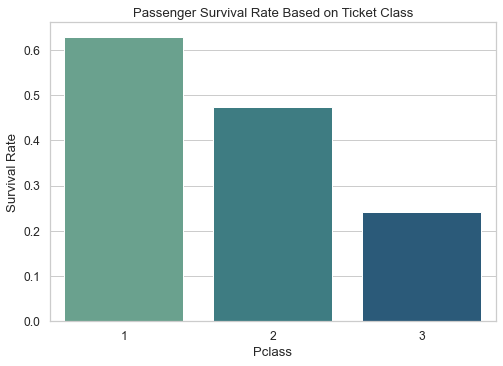

In [6]:
# Plot survival rate based on ticket class

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Table form
pclass_survival = train.pivot_table(values='Survived', index='Pclass')

# Set figure size for Jupyter Notebook once
plt.rcParams['figure.figsize'] = [8, 5.5]

# Seaborn bar plot
sns.set(font_scale=1.1)
sns.set_style("whitegrid")
sns.barplot(x=pclass_survival.index, y='Survived', data=pclass_survival, palette='crest')
plt.title("Passenger Survival Rate Based on Ticket Class")
plt.ylabel("Survival Rate")

display(pclass_survival)
plt.show()

Passengers with a higher ticket class (`Pclass` = 1) have a much higher chance of survival (more than double the rate of third class passengers). Survival rate of second class passengers are also almost double that of third class passengers. From this, we can glean that first and second class passengers might have been prioritized for survival. What's more is that the majority of the passengers are third class, more than first and second class combined.

In [7]:
print("Number of passengers in each ticket class:")
train['Pclass'].value_counts().sort_index()

Number of passengers in each ticket class:


1    216
2    184
3    491
Name: Pclass, dtype: int64

## 2.3 Sex

,Survived
Sex,
female,0.742038
male,0.188908


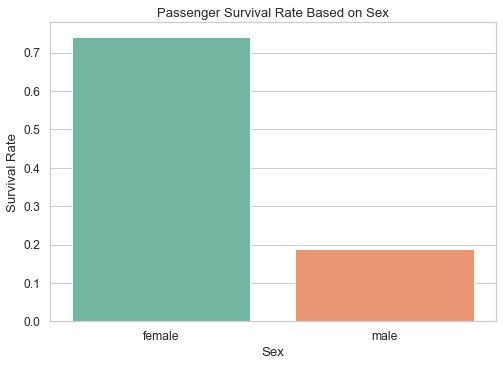

In [8]:
# Plot survival rate based on sex
sex_survival = train.pivot_table(values='Survived', index='Sex')

sns.set(font_scale=1.1)
sns.set_style("whitegrid")
sns.barplot(x=sex_survival.index, y='Survived', data=sex_survival, palette='Set2')
plt.title("Passenger Survival Rate Based on Sex")
plt.ylabel("Survival Rate")

display(sex_survival)
plt.show()

Female passengers have an incredibly higher survival rate, more than three times that of male passengers. It seeems that women were prioritized over men for survival.

Let's take a look if this is consistent throughout the ticket classes.

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

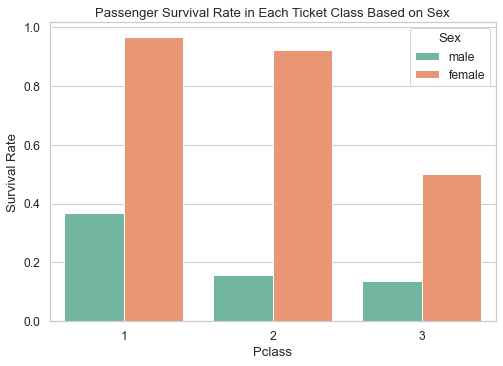

In [9]:
# Plot survival rate based on sex for each ticket class

# Table form
pclass_sex_survival = train.pivot_table(values='Survived', index=['Pclass', 'Sex'])
display(pclass_sex_survival)

# Seaborn bar plot
sns.set(font_scale=1.1)
sns.set_style("whitegrid")
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train, palette='Set2', ci=None)
plt.title("Passenger Survival Rate in Each Ticket Class Based on Sex")
plt.ylabel("Survival Rate")

plt.show()

The plot above confirms that female passengers were heavily prioritized. Let's take a look at the raw count below.

Survived         0   1
Pclass Sex            
1      female    3  91
       male     77  45
2      female    6  70
       male     91  17
3      female   72  72
       male    300  47

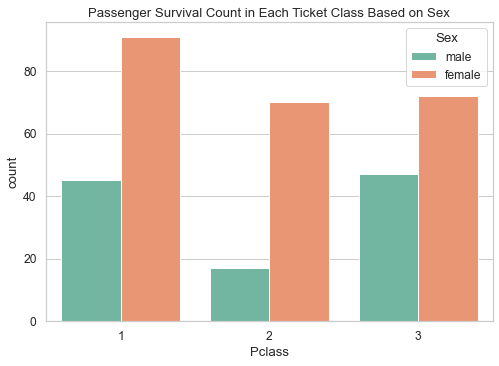

In [10]:
# Plot survival count for each sex in each ticket class

# Table form
display(pd.crosstab([train['Pclass'],train['Sex']], train['Survived']))

# Seaborn count plot
sns.set(font_scale=1.1)
sns.set_style("whitegrid")
sns.countplot(x='Pclass', hue='Sex', data=train[train['Survived']==1], palette='Set2', hue_order=['male','female'])
plt.title("Passenger Survival Count in Each Ticket Class Based on Sex")

plt.show()

Even though lower class women had a 50% survival rate, there were still more of them who survived compared to upper class men. 

Let's now one-hot encode the column.

In [11]:
train = create_dummies(train, 'Sex')
train = train.drop('Sex_male', axis=1) # because redundant info
holdout = create_dummies(holdout, 'Sex')
holdout = holdout.drop('Sex_male', axis=1)

train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sex_female'],
      dtype='object')

## 2.4 Cabin
Let's now tackle the column with about 77% missing data.

In [12]:
train['Cabin'].value_counts(dropna=False)

NaN            687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

`Cabin` looks like it has a large number of unique values. The values look like they're comprised of a letter followed by a one-, two-, or three-digit number. A quick Google search of the Titanic cabin layout lead me to believe that these values are decks and room numbers. Let's take a look into the deck values.

In [13]:
train['Cabin'].str[0].value_counts(dropna=False)

NaN    687
C       59
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: Cabin, dtype: int64

This seems better as we now have a fewer number of unique values. We'll deal with the missing values by filling them with "Unknown".

In [14]:
def process_cabin(df):
    """
    Process the Cabin column into pre-defined 'bins' 

    """
    
    df["Deck"] = df["Cabin"].str[0]
    df["Deck"] = df["Deck"].fillna("Unknown")
    df = df.drop('Cabin', axis=1)
    
    return df

train = process_cabin(train)
holdout = process_cabin(holdout)

Let's visualize survival based on which deck a passenger was in.

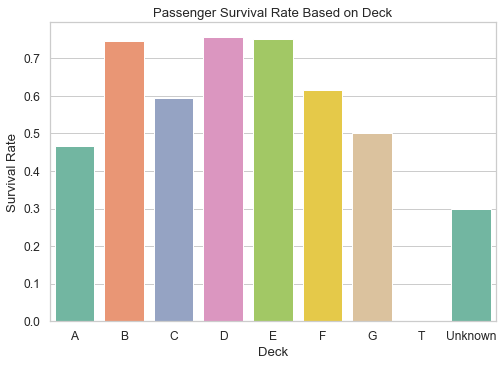

In [15]:
# Plot `Deck` against survival rate

deck_survival = train.pivot_table(values='Survived', index='Deck')

sns.set_style("whitegrid")
sns.barplot(x=deck_survival.index, y='Survived', data=deck_survival, palette="Set2")
plt.title("Passenger Survival Rate Based on Deck")
plt.ylabel("Survival Rate")

plt.show()

Except for `Deck_T`, it seems that those without deck data have the lowest survival rate. A look into the data shows that there was only one passenger who had the T deck value. There's not much disparity between differing decks except for between `Deck_Unknown` and the rest. 

Let's take a look at the relationship between `Deck` and `Pclass` to see if we can glean more information.

In [16]:
ct = pd.crosstab(train['Deck'], train['Pclass'])
ct

Pclass,1,2,3
Deck,,,
A,15,0,0
B,47,0,0
C,59,0,0
D,29,4,0
E,25,4,3
F,0,8,5
G,0,0,4
T,1,0,0
Unknown,40,168,479


It looks like Unknown deck data is correlated with lower class passengers. Decks A, B, and C are composed of only first class passengers. Not counting Unknown deck data, second class passengers only occupy decks D, E, and F, and third class passengers only show up in lower decks E, F, and G. The two features seem to be correlated. Let's visualize this with survival rate.

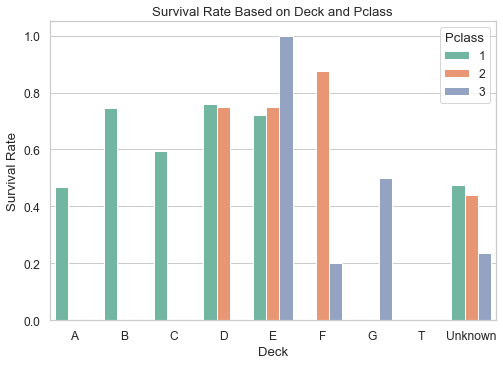

In [17]:
deck_pclass_survival = train.pivot_table(index=['Deck','Pclass'], values='Survived').reset_index()

sns.barplot(data=deck_pclass_survival, x='Deck', hue='Pclass', y='Survived', ci=None, palette='Set2')
plt.ylabel("Survival Rate")
plt.title("Survival Rate Based on Deck and Pclass")

plt.show()

It looks as if first class passengers occupy more of the upper decks (A, B, C), second class passengers middle decks (D, E, F), and third class passengers lower deck (E, F, G). `Deck` seems to be correlated with `Pclass`, so we'll drop it. 

We can also confirm the high correlation between `Deck` and `Pclass` below.

In [18]:
# Convert nominal to ordinal in order to calculate correlation
train['Deck'] = train['Deck'].astype('category')
train['Deck'] = train['Deck'].cat.codes                                                      
train['Deck'] = train['Deck'].astype(int)

print("Correlation of Deck and Pclass:",train.corr()['Deck']['Pclass'])

Correlation of Deck and Pclass: 0.7466157070176257


## 2.5 Embarked

In [19]:
train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


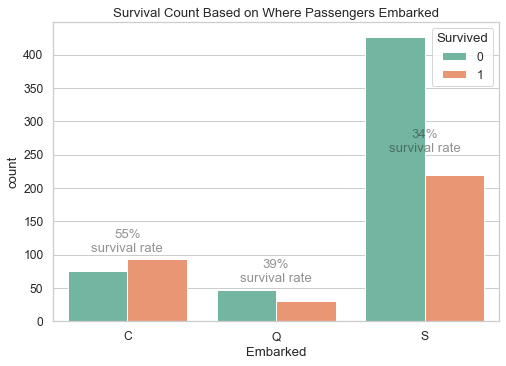

In [20]:
# Survival rate based on where passengers embarked
embarked_survival = train.pivot_table(index='Embarked', values='Survived')
display(embarked_survival)

# Survival count based on where passengers embarked
sns.set(font_scale=1.1)
sns.set_style("whitegrid")
sns.countplot(x='Embarked', hue='Survived', data=train, palette='Set2', order=embarked_survival.index)
plt.title("Survival Count Based on Where Passengers Embarked")
plt.text(0,105,"55%\nsurvival rate", horizontalalignment='center', alpha=0.5)
plt.text(1,60,"39%\nsurvival rate", horizontalalignment='center', alpha=0.5)
plt.text(2,255,"34%\nsurvival rate", horizontalalignment='center', alpha=0.5)

plt.show()

The plot looks interesting. A majority of the passengers embarked from Southampton, which had the lowest survival rate. Let's see if there's a correlation between port of embarkation and ticket class.

In [21]:
train.pivot_table(index=['Pclass', 'Embarked'], values='Survived')
e_corr = train[['Embarked','Pclass','Sex','Survived']].groupby(['Embarked','Pclass','Sex']).agg(['sum','count','mean'])
e_corr.columns = ['Survived','Total Passengers','Survival Rate']
e_corr

Survived  Total Passengers  Survival Rate
Embarked Pclass Sex                                              
C        1      female        42                43       0.976744
                male          17                42       0.404762
         2      female         7                 7       1.000000
                male           2                10       0.200000
         3      female        15                23       0.652174
                male          10                43       0.232558
Q        1      female         1                 1       1.000000
                male           0                 1       0.000000
         2      female         2                 2       1.000000
                male           0                 1       0.000000
         3      female        24                33       0.727273
                male           3                39       0.076923
S        1      female        48                50       0.960000
                male          28                79       0.354430
         2      female        61                67       0.910448
                male          15                97       0.154639
         3      female        33                88       0.375000
                male          34               265       0.128302

It seems that the majority of lower class male passengers embarking from Southampton widely contributes to Southampton's low survival rate, and we know that lower class passengers, especially men, have lower survival rates. Hence, I don't think `Embarked` gives us new information.

More importantly, it doesn't make sense that the port of embarkation would matter in who survived aboard the ship. We'll drop this column.

## 2.5 Age
Let's now analyze the `Age` column, which has about 20% missing data.

In [22]:
train['Age'].isnull().sum()

177

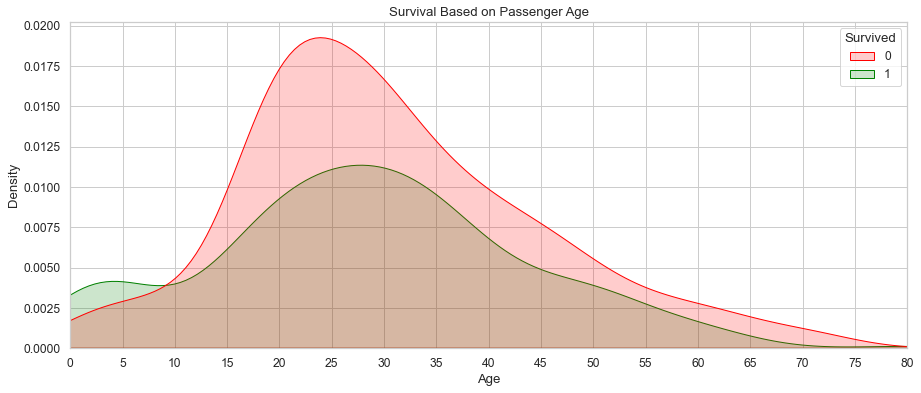

In [23]:
# Plot survival based on passenger age
import numpy as np

# Set figure size
plt.rcParams['figure.figsize'] = [15, 6]

# Plot kernel density estimate plot
sns.set_style("whitegrid")
sns.kdeplot(data=train, x='Age', hue='Survived', fill=True, palette=["red", "green"], alpha=0.2)

min_age = train['Age'].min()
max_age = train['Age'].max()
plt.xticks(np.arange(np.floor(min_age), np.ceil(max_age) + 1, 5))
plt.xlim(np.floor(min_age), np.ceil(max_age))
plt.title("Survival Based on Passenger Age")

plt.show()

Based on our plot above,
* Most passengers are more likely to die than to survive, with passengers between the ages of ~18 and 35 having an incredibly high chance of dying
* Children (Age < 10) have a much higher chance of survival (tapering off from 5 to 9)
* Ultimately, age seems to be an important feature in determining survival, particularly the dynamic between children who are more likely to survive and other age groups who are more likely to die
* We can reason from this data that along with women, children were likely prioritized for survival


We'll turn our attention to the `Name` column for now to deal with the missing age values. If we take a look into the `Name` of a passenger, we can glean their title from it. We'll extract these titles and utilize them in filling in the missing ages. Then, we'll cluster the ages afterwards.

### 2.5.1 Extracting Title from Name

In [24]:
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Notice that a passenger has a title in their name (Mr., Mrs., Miss., etc.). 

In [25]:
# Extract titles
combined = pd.concat([train['Name'], holdout['Name']])
combined.str.extract(' ([A-Za-z]+)\.').value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Ms            2
Major         2
Mme           1
Capt          1
Lady          1
Jonkheer      1
Dona          1
Don           1
Countess      1
Sir           1
dtype: int64

There are a lot of unique values for title, so we'll try to bin them. `Miss` and `Mlle` typically refer to an unmarried woman, so we'll group `Mlle` with `Miss`. We'll also group `Mme` with `Mrs` since they typically refer to a married woman. `Ms` can refer to either `Miss` or `Mrs`; we'll join it with `Mrs`. We'll keep `Mr` and `Master` (young boys under 18) as is. For the rest, we'll categorize them as either an `Officer` or `Nobility`.

In [26]:
def process_titles(df):
    """
    Extract and categorize the title from the name column 

    """
    
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Nobility",
        "Don":         "Nobility",
        "Dona":        "Nobility",
        "Sir" :        "Nobility",
        "Countess":    "Nobility",
        "Lady" :       "Nobility"
    }
    
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
    df["Title"] = extracted_titles.map(titles)
    
    return df

train = process_titles(train)
holdout = process_titles(holdout)
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Sex_female', 'Deck', 'Title'],
      dtype='object')

In [27]:
# Survival rate based on passenger title and sex
train.pivot_table(index=['Title', 'Sex'], values='Survived')

Survived
Title    Sex             
Master   male    0.575000
Miss     female  0.701087
Mr       male    0.156673
Mrs      female  0.795276
Nobility female  1.000000
         male    0.333333
Officer  female  1.000000
         male    0.235294

I'm not convinced that we can gain new information for our model from `Title` that's not already covered by `Sex` and would be by `Age` (for boys whose survival rate is higher than men). These survival rates seem to be attributed by the `Sex` of the passengers. The high survival rate of `Master` supports our findings that women and children were prioritized for survival. Ultimately, it seems that `Title` and `Sex` are correlated, so we won't one-hot encode it and will drop it after our data analysis.

### 2.5.2 Utilize Title for Missing Age Values
For each `Title` and `Sex`, we'll take the average age of passengers and use that to fill in the missing age values. This would be a more precise way compared to simply filling in with the mean of the `Age` column or binning missing values with a `Missing` label. This is especially important for passengers who are children. 

In [28]:
train[train['Age'].isnull()]['Survived'].mean()

0.2937853107344633

We see above how low the survival rate is for passengers with missing age values. We wouldn't want women and children, who have high survival rates, to be associated with a low survival rate because of their missing age value.

In [29]:
# Mean age of young boys
train[train['Title']=='Master']['Age'].mean()

4.574166666666667

In [30]:
# Mean age of 'Miss' title
train[train['Title']=='Miss']['Age'].mean()

21.804054054054053

I think it's highly important to fill in the missing ages of children, since they have a high survival rate. However, only male children have a specific `Title` of `Master`. Female children fall under `Miss` along with unmarried female adults. It's mentioned in Kaggle that some children traveled only with a nanny, hence the `Parch` = 0 for them. We'll ignore this detail and assume that a majority of children traveled with their parents.

In [31]:
# Mean age of 'Miss' title who traveled with parents
train[(train['Title']=='Miss') & (train['Parch'] > 0)]['Age'].mean()

11.863636363636363

This is a much better age to use to fill in for female children. We'll change the title of `Miss` to `MissChild` for those who traveled with their parents.

In [32]:
train.loc[(train['Title']=='Miss') & (train['Parch'] > 0), 'Title'] = 'MissChild'

In [33]:
# Mean age of 'Miss' title who didn't travel with parents
train[train['Title']=='Miss']['Age'].mean()

27.682795698924732

Let's make a pivot table for easy lookup of mean `Age` based on `Pclass`, `Sex`, and `Title`.

In [34]:
piv = train.pivot_table(index=['Pclass','Title', 'Sex'], values='Age')
piv

Age
Pclass Title     Sex              
1      Master    male     5.306667
       Miss      female  34.258065
       MissChild female  21.000000
       Mr        male    41.580460
       Mrs       female  40.400000
       Nobility  female  40.500000
                 male    42.333333
       Officer   female  49.000000
                 male    51.125000
2      Master    male     2.258889
       Miss      female  30.500000
       MissChild female  10.538462
       Mr        male    32.768293
       Mrs       female  33.547619
       Officer   male    42.000000
3      Master    male     5.350833
       Miss      female  21.697674
       MissChild female   6.903846
       Mr        male    28.724891
       Mrs       female  33.515152

In [35]:
# How to index
piv.loc[2, 'Miss', 'female']['Age']

30.5

We'll now fill in the missing age values.

In [36]:
def process_missing_age(row):
    """
    Returns the mean age on the pivot table based on `Title` and `Sex`
    """
    return piv.loc[row['Pclass'], row['Title'], row['Sex']]['Age']

In [37]:
# Replace missing age values with mean age based on `Sex` and `Title`
train['Age'] = train.apply(lambda x: process_missing_age(x) if pd.isnull(x['Age']) else x['Age'], axis=1)

In [38]:
train['Age'].isnull().sum()

0

Great! We successfully filled in the missing age values. Let's do the same with the test data using the same pivot table for training data.

In [39]:
holdout['Age'] = holdout.apply(lambda x: process_missing_age(x) if pd.isnull(x['Age']) else x['Age'], axis=1)
holdout['Age'].isnull().sum()

0

### 2.5.3 Age Bins
After we've filled in the null values for `Age`, we're now ready to cluster them.

In [40]:
# Use KMeans to cluster Age
from sklearn.cluster import KMeans

X = train[['Age','Survived']].copy()
km = KMeans(5, random_state=1).fit(X)
X['cluster'] = km.labels_

# Sort Age ranges by ascending
age_clusters = pd.concat([X.groupby('cluster')['Age'].min().sort_values(), X.groupby('cluster')['Age'].max().sort_values()], axis=1)
age_clusters.columns = ["min Age", "max Age"]
display(age_clusters)

,min Age,max Age
cluster,,
3,0.42,12.0
1,13.00,25.0
2,26.00,37.0
0,38.00,52.0
4,53.00,80.0


In [41]:
def process_age(df):
    """
    Process the Age column into pre-defined 'bins' 

    """
    
    cut_points = [0, 12, 25, 37, 52, 100]
    label_names = ["0-12","13-25","26-37","38-52","53+"]
    df["AgeBand"] = pd.cut(df["Age"], cut_points, labels=label_names)
    
    return df

train = process_age(train)
holdout = process_age(holdout)

In [42]:
# convert nominal to ordinal
train['AgeBand'] = train['AgeBand'].cat.codes.astype(int)
holdout['AgeBand'] = holdout['AgeBand'].cat.codes.astype(int)

In [43]:
# Survival rate based on age group
train.pivot_table(index=['AgeBand'], values='Survived')

,Survived
AgeBand,
0,0.524390
1,0.398438
2,0.336310
3,0.403614
4,0.333333


This data looks promising. We'll move on to the next possible feature.

In [44]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Sex_female', 'Deck', 'Title',
       'AgeBand'],
      dtype='object')

## 2.6 Fare

In [45]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

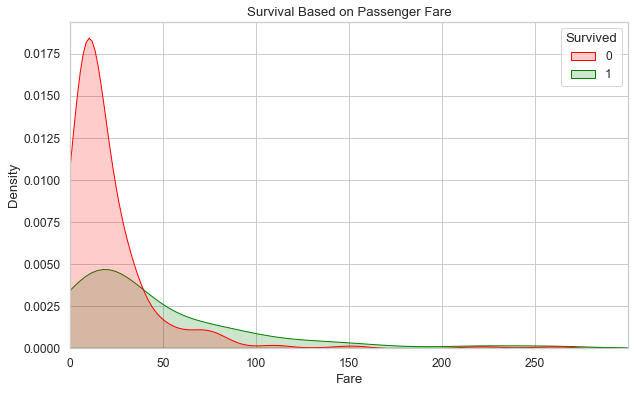

In [46]:
# Plot of survival rate based on passenger fare

# Set figure size
plt.rcParams['figure.figsize'] = [10, 6]

# Plot kernel density estimate plot
sns.set_style("whitegrid")
sns.kdeplot(data=train, x='Fare', hue='Survived', fill=True, palette=["red", "green"], alpha=0.2)

min_fare = train['Fare'].min()
max_fare = train['Fare'].max()
plt.xticks(np.arange(np.floor(min_fare), 300, 50))
plt.xlim(np.floor(min_fare), 300)
plt.title("Survival Based on Passenger Fare")

plt.show()

We see that survival rate increases as `Fare` increases, which makes sense. It's likely that `Fare` is correlated with `Pclass`. A passenger with a higher `Fare` is morely likely to be in first or second class rather than third class. We can see the progression below.

In [47]:
# Correlation of `Fare` with Pclass
train = create_dummies(train, 'Pclass')
display(train.corr()['Fare'][['Pclass_1', 'Pclass_2', 'Pclass_3', 'Pclass']])
train = train.drop(['Pclass_1', 'Pclass_2', 'Pclass_3'], axis=1)

Pclass_1    0.591711
Pclass_2   -0.118557
Pclass_3   -0.413333
Pclass     -0.549500
Name: Fare, dtype: float64

The correlation between `Fare` and `Pclass` is pretty high, but not the worst we've seen. Let's visualize their relationship.

First, we'll cluster `Fare`, then visualize the clusters.

In [48]:
# Use KMeans to cluster Fare
from sklearn.cluster import KMeans

X = train[['Fare','Survived']].copy()
km = KMeans(5, random_state=1).fit(X)
X['cluster'] = km.labels_

fare_clusters = pd.concat([X.groupby('cluster')['Fare'].min().sort_values(), X.groupby('cluster')['Fare'].max().sort_values()], axis=1)
fare_clusters.columns = ["min Fare", "max Fare"]
display(fare_clusters)

,min Fare,max Fare
cluster,,
0,0.0000,40.1250
3,41.5792,93.5000
1,106.4250,164.8667
4,211.3375,263.0000
2,512.3292,512.3292


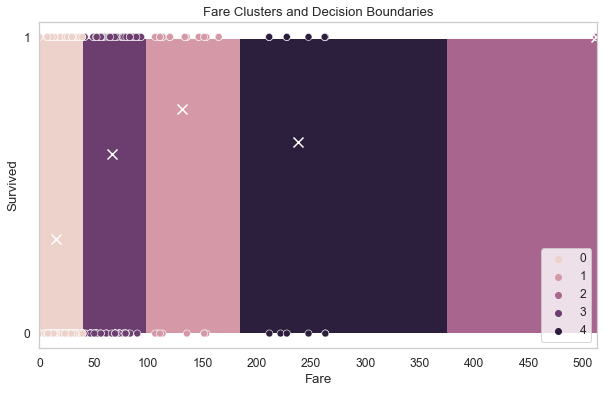

In [49]:
# Visualize Fare clusters

# Take out the grid
sns.set_style("whitegrid", {'axes.grid' : False})

### Plotting the decision boundaries ###
# from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.01  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each.
x_min, x_max = X['Fare'].min(), X['Fare'].max()+1
y_min, y_max = X['Survived'].min(), X['Survived'].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = km.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation="nearest", 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           aspect="auto", cmap=sns.cubehelix_palette(as_cmap=True))

#Plot the Fares
sns.scatterplot(x='Fare', y='Survived', hue='cluster', data=X, s=50)

# Plot the centroids as a white X
centroids = km.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", color='w', s=100)

plt.ylim(-0.05,1.05)
plt.yticks([0,1])
plt.xticks(np.arange(0,550,50))
plt.legend(loc='lower right')
plt.title("Fare Clusters and Decision Boundaries")

plt.show()

We see based on the centroids on the plot that there's a general trend of higher survival rate as `Fare` increases.

We'll create bins based on the clusters above. Then, we can visualize the relationship between each cluster and `Pclass`.

In [50]:
def process_fare(df):
    """
    Process the Fare column into pre-defined 'bins' 

    """
    
    cut_points = [-1, 41, 100, 185, 375, 1000]
    label_names = ["0-41", "41-100", "100-185", "185-375", "375+"]
    df["Fare"] = pd.cut(df["Fare"], cut_points, labels=label_names)
    
    return df

train = process_fare(train)
holdout = process_fare(holdout)

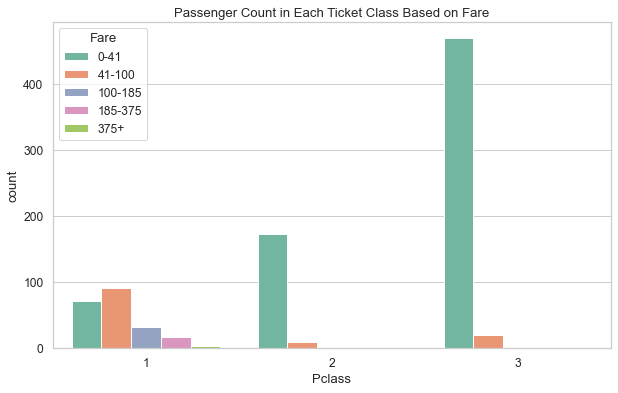

In [51]:
# Plot relationship between Pclass and Fare
sns.set(font_scale=1.1)
sns.set_style("whitegrid")
sns.countplot(x='Pclass', hue='Fare', data=train, palette='Set2')
plt.title("Passenger Count in Each Ticket Class Based on Fare")

plt.show()

From the plot above, we can attribute the higher `Fare`s more clearly to lower `Pclass` as they only show up in `Pclass`=1. As we increase the ticket class, we see that there are more passengers who paid a lower `Fare`, and we know that survival rate decreases as we increase `Pclass`. In conclusion, `Fare` seems to be correlated with `Pclass`. We can't quite say that `Fare` is independently correlated with `Survived`, so we'll drop it.

We've handled most of the features at this point. The ones we haven't are `SibSp`, `Parch`, and `Ticket`. We'll dive deeper into these features next.

## 2.7 SibSp and Parch
Let's turn our attention to two of our numerical features: `SibSp` and `Parch`.

In [52]:
explore = train[['SibSp', 'Parch', 'Survived']].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SibSp     891 non-null    int64
 1   Parch     891 non-null    int64
 2   Survived  891 non-null    int64
dtypes: int64(3)
memory usage: 21.0 KB


The `SibSp` column shows the number of siblings and/or spouses each passenger had on board, while the `Parch` column shows the number of parents and/or children each passenger had onboard. Neither column has any missing values.

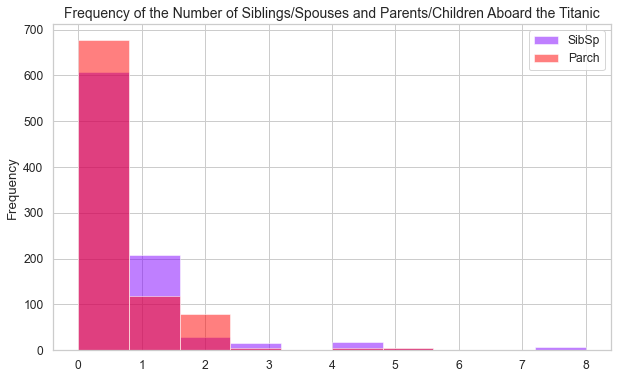

In [53]:
# Histogram plot

plt.rcParams['figure.figsize'] = [10, 6]

explore = explore.drop('Survived', axis=1) # Not relevant for histogram plots

# Seaborn bar plot
sns.set(font_scale=1.1)
sns.set_style("whitegrid")

explore.plot.hist(cmap='rainbow', alpha=0.5)
#sns.countplot(data=explore, x='SibSp', color='skyblue', alpha=0.3)
#sns.countplot(data=explore, x='Parch', color='red', alpha=0.7)
plt.title("Frequency of the Number of Siblings/Spouses and Parents/Children Aboard the Titanic", size=14)

plt.show()

In [54]:
explore['SibSp'].value_counts().sort_index()

0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: SibSp, dtype: int64

In [55]:
explore['Parch'].value_counts().sort_index()

0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parch, dtype: int64

The distribution of values in both columns is skewed right, with the majority of values being zero.

We can sum the two columns to explore the total number of family members each passenger had onboard. 

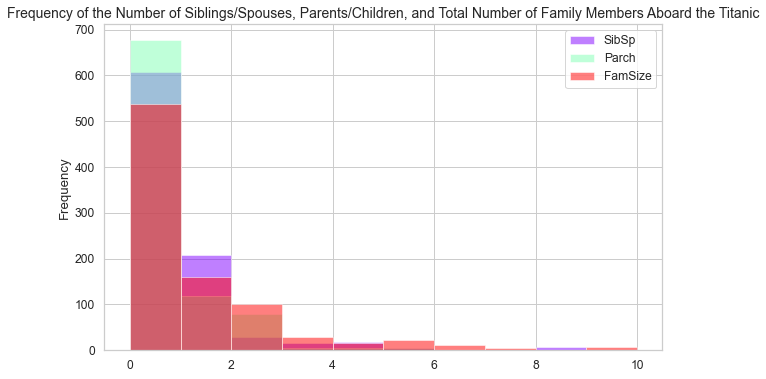

In [56]:
# Adding a family size feature to the histogram
explore['FamSize'] = explore.sum(axis=1) # SibSp + Parch for every passenger
explore.plot.hist(cmap='rainbow',alpha=0.5)
plt.title("Frequency of the Number of Siblings/Spouses, Parents/Children, and Total Number of Family Members Aboard the Titanic", size=14)

plt.show()

The shape of the distribution of values in this case is similar; however, there are fewer values at zero, and the quantity tapers off less rapidly as the values increase.

Let's take a look at the percentage of survivors with respect to `SibSp`, `Parch`, and `FamSize`.

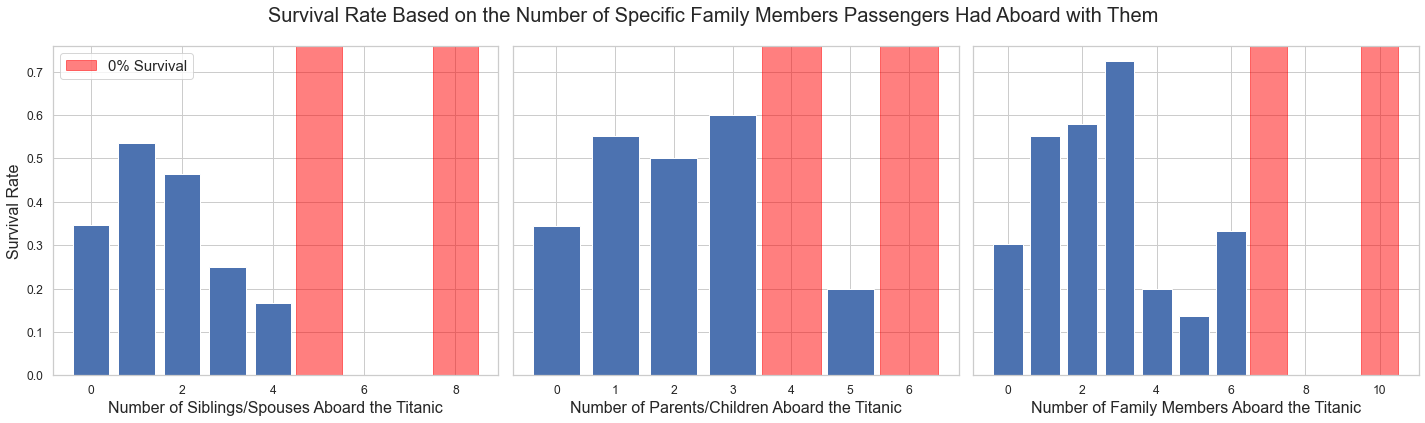

In [57]:
# Create a pivot table for SibSp, Parch, FamSize and plot the results in bar plot form
import matplotlib.patches as mpatches

# Add target column back in the DataFrame
explore['Survived'] = train['Survived']

# For x-axis label
feature_dict = {'SibSp': "Siblings/Spouses",
                'Parch': "Parents/Children",
                'FamSize': "Family Members"}

# Make the plots
fig, ax = plt.subplots(1,3, figsize=(20,6), sharex=False, sharey=True)
count=0
for col in explore.drop('Survived', axis=1).columns:
    pivot = explore.pivot_table(index=col, values='Survived')
    
    ax[count].bar(pivot.index, pivot['Survived'])
    ax[count].set(xlabel="Number of {} Aboard the Titanic".format(feature_dict[col]))
    ax[count].xaxis.label.set_size(16)
    ax[count].yaxis.label.set_size(16)
    
    # Highlight red where percentage of passengers who survived is 0
    zero_survival = pivot.loc[pivot['Survived']==0].index
    for i in zero_survival:
        ax[count].axvspan(i-0.5, i+0.5, color='red', alpha=0.5)
    
    count+=1

# One title and one y-axis label for all plots
plt.suptitle("Survival Rate Based on the Number of Specific Family Members Passengers Had Aboard with Them", fontsize=20)
ax[0].set_ylabel("Survival Rate")

# One legend for all plots
red_patch = mpatches.Patch(color='red', label='0% Survival', alpha=0.5)
ax[0].legend(handles=[red_patch], fontsize=15)

# Automatically adjust subplots to fit in whole area
fig.tight_layout()

Looking at the survival rates of the the combined family members, you can see that few of the passengers with no family members survived (only 30%), while a greater number of passengers with family members survived.

However, we should also note that the graphs are skewed right, meaning that <i>too many</i> family members with the passenger garnered a survival rate of 0% as seen with the red bars. We can see this in the table below as well.

In [58]:
# Table version of plots above
# Survival rate based on the number of specific family members aboard with passenger
# NaN values indicate no passenger had that amount of family members aboard the Titanic
fam_survival = pd.concat([explore.pivot_table(index="SibSp", values='Survived'), explore.pivot_table(index="Parch", values='Survived')], axis=1)
fam_survival = pd.concat([fam_survival, explore.pivot_table(index="FamSize", values='Survived')], axis=1)
fam_survival.columns = ["SibSp Survival", "Parch Survival", "FamSize Survival"]
fam_survival

,SibSp Survival,Parch Survival,FamSize Survival
0,0.345395,0.343658,0.303538
1,0.535885,0.550847,0.552795
2,0.464286,0.500000,0.578431
3,0.250000,0.600000,0.724138
4,0.166667,0.000000,0.200000
5,0.000000,0.200000,0.136364
6,NaN,0.000000,0.333333
7,NaN,NaN,0.000000
8,0.000000,NaN,NaN
10,NaN,NaN,0.000000


From our analysis, it seems better to combine `SibSp` and `Parch` together. Let's add the `FamSize` feature to our datasets.

In [59]:
for df in [train, holdout]:
    df['FamSize'] = df[['SibSp', 'Parch']].sum(axis=1)

train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Sex_female', 'Deck', 'Title',
       'AgeBand', 'FamSize'],
      dtype='object')

## 2.8 Ticket
Let's now take a look into `Ticket`. At first glance, it seems that each `Ticket` entry is unique to a passenger. However, it looks like multiple passengers can have the same `Ticket` value. We'll infer that passengers who traveled together have identical `Ticket` values.

In [60]:
train['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

Let's plot the survival rate based on the number of passengers in a party.

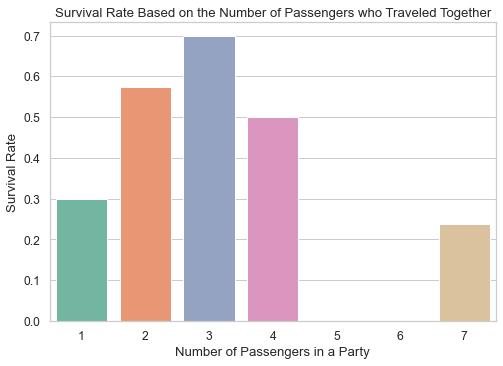

In [61]:
# Replace `Ticket` column values with the number of people in the passenger's party 
train['n_Ticket'] = train['Ticket'].replace(train['Ticket'].value_counts())
holdout['n_Ticket'] = holdout['Ticket'].replace(holdout['Ticket'].value_counts())

# Plot the survival percentage with respect to number of people in the party
plt.rcParams['figure.figsize'] = [8, 5.5]
sns.set(font_scale=1.1)
sns.set_style('whitegrid')

sns.barplot(data=train, x='n_Ticket', y='Survived', ci=None, palette='Set2')
plt.title("Survival Rate Based on the Number of Passengers who Traveled Together")
plt.xlabel("Number of Passengers in a Party")
plt.ylabel("Survival Rate")

plt.show()

It seems that traveling in a group is better for survival, compared to traveling alone. However, too many passengers traveling together lowers survival rate, as seen with having more than 4 people in a party.

With this in mind, we'll engineer a new feature.

# 3. Feature Engineering
We'll engineer two new features:
* `isAlone`: whether the passenger traveled alone or not
* `inWCg`: whether the passenger is in a woman-child group or not

## 3.1 Engineer isAlone
Based on our exploration of the data, we can engineer a new feature: whether the passenger was alone or not.
* `1` if the passenger has zero family members onboard and traveled alone
* `0` if the passenger has one or more family members onboard or traveled in a group

In [62]:
def process_isalone(df):
    """
    Process 'FamSize' and 'n_Ticket' columns to determine if passenger traveled alone
    """
    
    # If passenger's family size is 0 and has a unique ticket, they traveled alone
    df['isAlone'] = df.apply(lambda x: 1 if (x['FamSize']==0) & (x['n_Ticket']==1) else 0, axis=1)
    
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)
print("Number of solo passengers:",train[train['isAlone']==1].shape[0])

Number of solo passengers: 462


,Survived
isAlone,
0,0.505828
1,0.270563


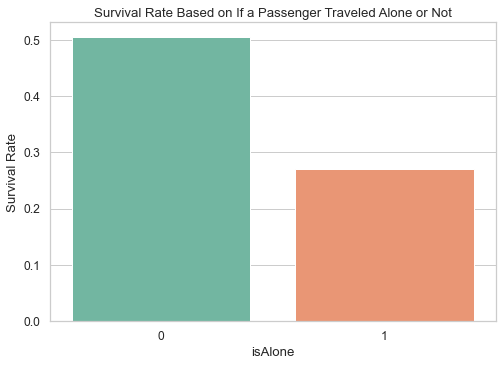

In [63]:
# Plot survival rate based on if passenger was alone

display(train.pivot_table(index='isAlone', values='Survived'))

sns.barplot(data=train, x='isAlone', y='Survived', ci=None, palette='Set2')
plt.ylabel("Survival Rate")
plt.title("Survival Rate Based on If a Passenger Traveled Alone or Not")

plt.show()

We see that survival rate is almost double for passengers who traveled in a group. 

We'll drop `FamSize` and `n_Ticket` at the end, since they're correlated with `isAlone`.

## 3.2 Engineer inWCg

From our data analysis, we have gleaned that women and children were prioritized for survival, since they have significantly higher rates of survival. Woman-child groups are female or boy (`Master` title) passengers traveling together. 

We'll engineer another new feature: whether the passenger is in a woman-child group or not.
* `1` if a passenger who is traveling in a group is either a woman or a child
* `0` if not

In [64]:
def process_inWCg(df):
    """
    Process `isAlone`, `Sex_female`, and `Title` to determine if
    passenger is either woman or child and traveled in a group
    """
    df['inWCg'] = df.apply(lambda x: 1 if (x['isAlone']==0) & ((x['Sex_female']==1) or (x['Title']=='Master')) else 0, axis=1)
    return df

train = process_inWCg(train)
holdout = process_inWCg(holdout)

We see below that passengers in a woman-child group are likely to share the same fate.

In [65]:
train[(train['inWCg']==1)].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_female,Deck,Title,AgeBand,FamSize,n_Ticket,isAlone,inWCg
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,41-100,C,1,2,Mrs,3,1,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,41-100,S,1,2,Mrs,2,1,2,0,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,0-41,S,0,8,Master,0,4,4,0,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,0-41,S,1,8,Mrs,2,2,3,0,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,0-41,C,1,8,Mrs,1,1,2,0,1


In [66]:
# Family shared same fate (Survived==0)
train[train['Name'].str.contains('Palsson')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_female,Deck,Title,AgeBand,FamSize,n_Ticket,isAlone,inWCg
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,0-41,S,0,8,Master,0,4,4,0,1
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,0-41,S,1,8,MissChild,0,4,4,0,1
374,375,0,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,0-41,S,1,8,MissChild,0,4,4,0,1
567,568,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,0-41,S,1,8,Mrs,2,4,4,0,1


Now that we're done with analysis and engineering, we can drop the columns that we no longer need. 

In [67]:
train = train.drop(['PassengerId','Name', 'Sex', 'Age',
                    'SibSp', 'Parch',
                    'Ticket', 'Fare', 'Embarked', 'Deck', 'Title', 'n_Ticket'], axis=1)
holdout = holdout.drop(['Name', 'Sex', 'Age',
                        'SibSp', 'Parch',
                        'Ticket', 'Fare', 'Embarked', 'Deck', 'Title', 'n_Ticket'], axis=1)

print(train.columns)
print(holdout.columns)

Index(['Survived', 'Pclass', 'Sex_female', 'AgeBand', 'FamSize', 'isAlone',
       'inWCg'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Sex_female', 'AgeBand', 'FamSize', 'isAlone',
       'inWCg'],
      dtype='object')


# 4. Feature Scaling
In order to make sure values are equally weighted in the model, we need to rescale numeric features. Looking at our columns, we only need to scale `FamSize`.

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Survived    891 non-null    int64
 1   Pclass      891 non-null    int64
 2   Sex_female  891 non-null    uint8
 3   AgeBand     891 non-null    int64
 4   FamSize     891 non-null    int64
 5   isAlone     891 non-null    int64
 6   inWCg       891 non-null    int64
dtypes: int64(6), uint8(1)
memory usage: 42.8 KB


In [69]:
# Normalize data from 0 to 1
from sklearn.preprocessing import minmax_scale

cols = ['FamSize']
for col in cols:
    new_colname = col + '_scaled'
    train[new_colname] = minmax_scale(train[col])
    holdout[new_colname] = minmax_scale(holdout[col])
    train = train.drop(col, axis=1)
    holdout = holdout.drop(col, axis=1)

train.head()

,Survived,Pclass,Sex_female,AgeBand,isAlone,inWCg,FamSize_scaled
0,0,3,0,1,0,0,0.1
1,1,1,1,3,0,1,0.1
2,1,3,1,2,1,0,0.0
3,1,1,1,2,0,1,0.1
4,0,3,0,2,1,0,0.0


# 5. Feature Selection
We're now almost ready to train a model. We'll be using the following classifiers: k-Nearest Neighbors, Logistic Regression, and Random Forest. Before that, we'll select the best features for a Logistic Regression model and a Random Forest model. (Note that we can't do this for kNN)

<AxesSubplot:>

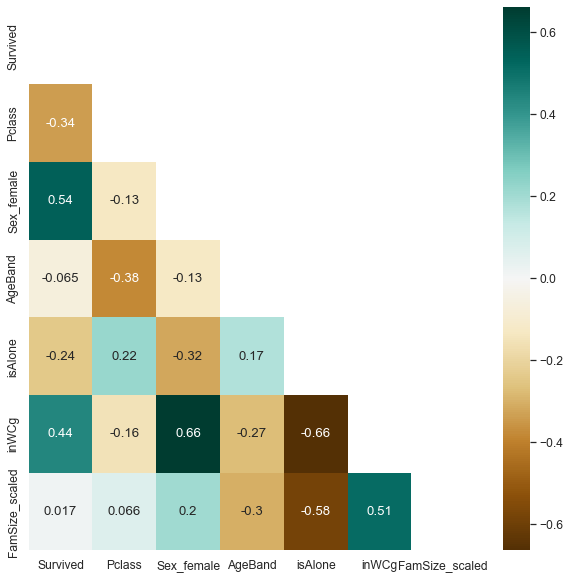

In [70]:
# Visualize a correlation heatmap for the purpose of dropping redundant features
import seaborn as sns

plt.subplots(figsize=(10,10))
mask = np.triu(np.ones_like(train.corr()))
sns.heatmap(train.corr(), cmap="BrBG", mask=mask, annot=True)

The highest correlation seems to be between `inWCg` and `Sex_female` and between `inWCg` and `isAlone`, which makes sense based on how we engineered `inWCg`. I believe it's still essential to keep all three as features, but let's do recursive feature elimination with cross-validation.

In [71]:
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def select_features(df, alg):
    """
    Uses RFECV to select the optimal columns for Logistic Regression or Random Forest Classifier
    
        Parameters:
            df (DataFrame): The DataFrame to work with
            alg (str): 'lr' for Logistic Regression
                       'rf' for Random Forest
                         
        Returns:
            list (pandas.Index) of features from df that are optimal for a model of the algorithm that was selected
    """
    
    X = df.drop(['Survived'], axis=1)
    y = df['Survived']
    
    if alg=='lr':
        estimator = LogisticRegression()
    elif alg=='rf':
        estimator = RandomForestClassifier(random_state=1)
    
    selector = RFECV(estimator, cv=10)
    selector.fit(X, y)
    
    #Select columns using mask of selected features from RFECV
    optimized_cols = X.columns[selector.support_]
    
    return optimized_cols

best_cols_lr = select_features(train, 'lr')
best_cols_rf = select_features(train, 'rf')

print("Best features for a Logistic Regression model: \n{}\n".format(best_cols_lr))
print("Best features for a Random Forest model: \n{}\n".format(best_cols_rf))

Best features for a Logistic Regression model: 
Index(['Pclass', 'Sex_female', 'AgeBand', 'isAlone', 'inWCg',
       'FamSize_scaled'],
      dtype='object')

Best features for a Random Forest model: 
Index(['Pclass', 'Sex_female', 'inWCg', 'FamSize_scaled'], dtype='object')



It looks like a Logistic Regression model agrees with us, while a Random Forest model drops `AgeBand` and `isAlone`.

# 6. Model Selection and Tuning

In [72]:
from sklearn.model_selection import GridSearchCV
from random import uniform, randint

def select_model(df, features, alg):
    """
    Uses GridSearchCV to select the best parameters for an estimator
    and returns a dictionary with all the values including the best estimator
    and the best score and best parameters associated with it
    
        Parameters:
            df (DataFrame): the DataFrame to work with
            features (pandas.Index): column names of the DataFrame to use as features
            alg (str): 'knn' for k-Nearest Neighbors
                       'lr' for Linear Regression
                       'rf' for Random Forest
        Returns:
            Dictionary of the best model of the algorithm that was chosen
            with the best parameters and values
    """
    
    X = df[features]
    y = df['Survived']
    models = [
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters": 
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2],
                "leaf_size": [randint(1,50)]
            }
        },
        
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
            {
                #"solver": ["newton-cg", "lbfgs", "liblinear", "sag"]
                "solver": ["liblinear"],
                "penalty": ['l1','l2'],
                "C": [uniform(0.01,10)]
            }
        },
        
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
            {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }
        }
    ]
    
    if alg=='knn':
        model = models[0]
    elif alg=='lr':
        model = models[1]
    elif alg=='rf':
        model = models[2]
        
    print(model["name"])
    grid = GridSearchCV(model["estimator"], param_grid=model["hyperparameters"], cv=10)
    grid.fit(X, y)
    model["best_params"] = grid.best_params_
    model["best_score"] = grid.best_score_
    model["best_model"] = grid.best_estimator_
        
    print("Best score:", model["best_score"])
    print("Best parameters:", model["best_params"], "\n")
        
    return model

# 7. Model training

In [73]:
# All features for kNN checking
all_features = train.drop('Survived',axis=1).columns
print("Using all features:")
result_knn_all_features = select_model(train, all_features, 'knn')

# Using the best features for Logistic Regression to get the best model for kNN
print("Using best features for a Logistic Regression model:")
result_knn_lr_features = select_model(train, best_cols_lr, 'knn')

# Using the best features for Random Forest to get the best model for kNN
print("Using best features for a Random Forest model:")
result_knn_rf_features = select_model(train, best_cols_rf, 'knn')

Using all features:
KNeighborsClassifier
Best score: 0.8215980024968788
Best parameters: {'algorithm': 'kd_tree', 'leaf_size': 25, 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'} 

Using best features for a Logistic Regression model:
KNeighborsClassifier
Best score: 0.8226841448189763
Best parameters: {'algorithm': 'kd_tree', 'leaf_size': 4, 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'} 

Using best features for a Random Forest model:
KNeighborsClassifier
Best score: 0.8271535580524343
Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 9, 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'} 



In [74]:
# Using the best features for a Logistic Regression model
print("Using best features:")
result_lr = select_model(train, best_cols_lr, 'lr')

# Using all features for a Logistic Regression model
print("Using all features:")
result_lr_all_features = select_model(train, all_features, 'lr')

Using best features:
LogisticRegression
Best score: 0.8103620474406992
Best parameters: {'C': 6.608866357484032, 'penalty': 'l1', 'solver': 'liblinear'} 

Using all features:
LogisticRegression
Best score: 0.8013607990012485
Best parameters: {'C': 0.49087178946917276, 'penalty': 'l1', 'solver': 'liblinear'} 



In [75]:
# Using the best features for a Random Forest model
print("Using best features:")
result_rf = select_model(train, best_cols_rf, 'rf')

# Using all features for a Logistic Regression model
print("Using all features:")
result_rf_all_features = select_model(train, all_features, 'rf')

Using best features:
RandomForestClassifier
Best score: 0.8350187265917602
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 9} 

Using all features:
RandomForestClassifier
Best score: 0.8384019975031209
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 9} 



It looks like if we wanted to use a k-Nearest Neighbors model, we get the best training accuracy score of 82.72% using the best features for a Random Forest model.

Looking at all the models we trained, it seems that using the Random Forest model with all the features gains us the best training accuracy score. We'll make predictions on the test set using each model and submit to Kaggle in order to see the test accuracy.

# 8. Submitting Predictions to Kaggle

In [76]:
def save_submission_file(trained_model, features, filename):
    """
    Creates a csv file of the survival predictions for the test set
    """
    
    holdout_predictions = trained_model.predict(holdout[features])
    submission = pd.DataFrame({'PassengerId': holdout['PassengerId'], 'Survived': holdout_predictions})
    submission.to_csv("{}.csv".format(filename), index=False)

In [77]:
# Using Linear Regression model with 80.7% training accuracy
#parameters: {'C': 0.6385119265659338, 'penalty': 'l1', 'solver': 'liblinear'}

#best 0.79485 accuracy
#save_submission_file(result_lr['best_model'], best_cols_lr, 'kaggle_submission_lr_')

In [78]:
# Using Random Forest model with 83.84% training accuracy
# parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 
#                'min_samples_split': 2, 'n_estimators': 9}

#0.77751 accuracy
#save_submission_file(result_rf_all_features['best_model'], all_features, 'kaggle_submission_rf_')

In [79]:
# Using kNN model with 82.72% training accuracy
# parameters: {'algorithm': 'ball_tree', 'leaf_size': 32, 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'} 

#0.77511 accuracy
#save_submission_file(result_knn_rf_features['best_model'], best_cols_rf, 'kaggle_submission_knn__')

# 9. Conclusion

Our best submission scored 0.79485 with a Linear Regression model. It was interesting to see that our model with the lowest training accuracy of 0.80698 scored the highest. The difference between the training and test accuracies in our other models (Random Forest and kNN) tells us that those models were overfitting. 

Next steps we can take to potentially improve the results:
* further tweak the hyperparameters for all models
* try other machine learning algorithms